In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt
import json

## 퀀트함수
from quant_functions import anal_funcs, data_funcs
import portfolio_obtimizer
import myfuncs
from fredapi import Fred
fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')

# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go
import seaborn as sns
sns.set_style('whitegrid')
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker
from matplotlib.ticker import LogLocator
import matplotlib.pyplot as plt
## figure size 설정
figsize=(12, 8)
plt.rcParams["figure.figsize"] = figsize
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

import graphModule as gm

## color 설정
with open('colors.json') as f:
    mycolors = json.load(f)

# 블루 테마
cmap_colors = ["#FFFFFF", mycolors['color_cont3'], mycolors['color_cont2']]
# LinearSegmentedColormap 생성
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", cmap_colors, N=256)    

## shock case
with open('shockCase.json', encoding='utf-8') as f:
    shock_cases = json.load(f)

In [8]:
def simple_volatility_drag_simulation_stay(days=20, start_price=100, change=0.03, keep = 3):
    # 초기 조건
    qqq_price = start_price
    tqqq_price = start_price
    qqq_prices = [qqq_price]
    tqqq_prices = [tqqq_price]

    # 매 3일 상승, 3일 하락 반복
    for day in range(1, days + 1):
        if (day // keep) % 2 == 0:  # 상승하는 3일
            _change = 1 / (1 - change)
        else:  # 하락하는 3일
            _change = 1 - change
        qqq_price = qqq_price * _change
        tqqq_price = tqqq_price * (1+((_change-1) * 3))
        # 가격 업데이트
        qqq_prices.append(qqq_price)
        tqqq_prices.append(tqqq_price)  # TQQQ는 3배 레버리지

    return tqqq_prices, qqq_prices

def simple_volatility_drag_simulation_bull(days=20, start_price=100, change=0.03):
    # 초기 조건
    qqq_price = start_price
    tqqq_price = start_price
    qqq_prices = [qqq_price]
    tqqq_prices = [tqqq_price]

    # 매 3일 상승, 3일 하락 반복
    for day in range(1, days + 1):
        _change = 1 + change
        qqq_price = qqq_price * _change
        tqqq_price = tqqq_price * (1+(change* 3))
        # 가격 업데이트
        qqq_prices.append(qqq_price)
        tqqq_prices.append(tqqq_price)  # TQQQ는 3배 레버리지

    return tqqq_prices, qqq_prices

def simple_volatility_drag_simulation_bear(days=20, start_price=100, change=0.03):
    # 초기 조건
    qqq_price = start_price
    tqqq_price = start_price
    qqq_prices = [qqq_price]
    tqqq_prices = [tqqq_price]

    # 매 3일 상승, 3일 하락 반복
    for day in range(1, days + 1):
        _change = 1 - change
        qqq_price = qqq_price * _change
        tqqq_price = tqqq_price * (1-(change* 3))
        # 가격 업데이트
        qqq_prices.append(qqq_price)
        tqqq_prices.append(tqqq_price)  # TQQQ는 3배 레버리지

    return tqqq_prices, qqq_prices

In [9]:
days = 20
keep = 2
change = 0.03

stay_df = pd.DataFrame(simple_volatility_drag_simulation_stay(days=days, change=change, keep=keep), index=['TQQQ', 'QQQ']).T
bull_df = pd.DataFrame(simple_volatility_drag_simulation_bull(days=days, change=change), index=['TQQQ', 'QQQ']).T
bear_df = pd.DataFrame(simple_volatility_drag_simulation_bear(days=days, change=change), index=['TQQQ', 'QQQ']).T

In [12]:
bear_df

,TQQQ,QQQ
0,100.000000,100.000000
1,91.000000,97.000000
2,82.810000,94.090000
3,75.357100,91.267300
4,68.574961,88.529281
5,62.403215,85.873403
6,56.786925,83.297200
7,51.676102,80.798284
8,47.025253,78.374336
9,42.792980,76.023106


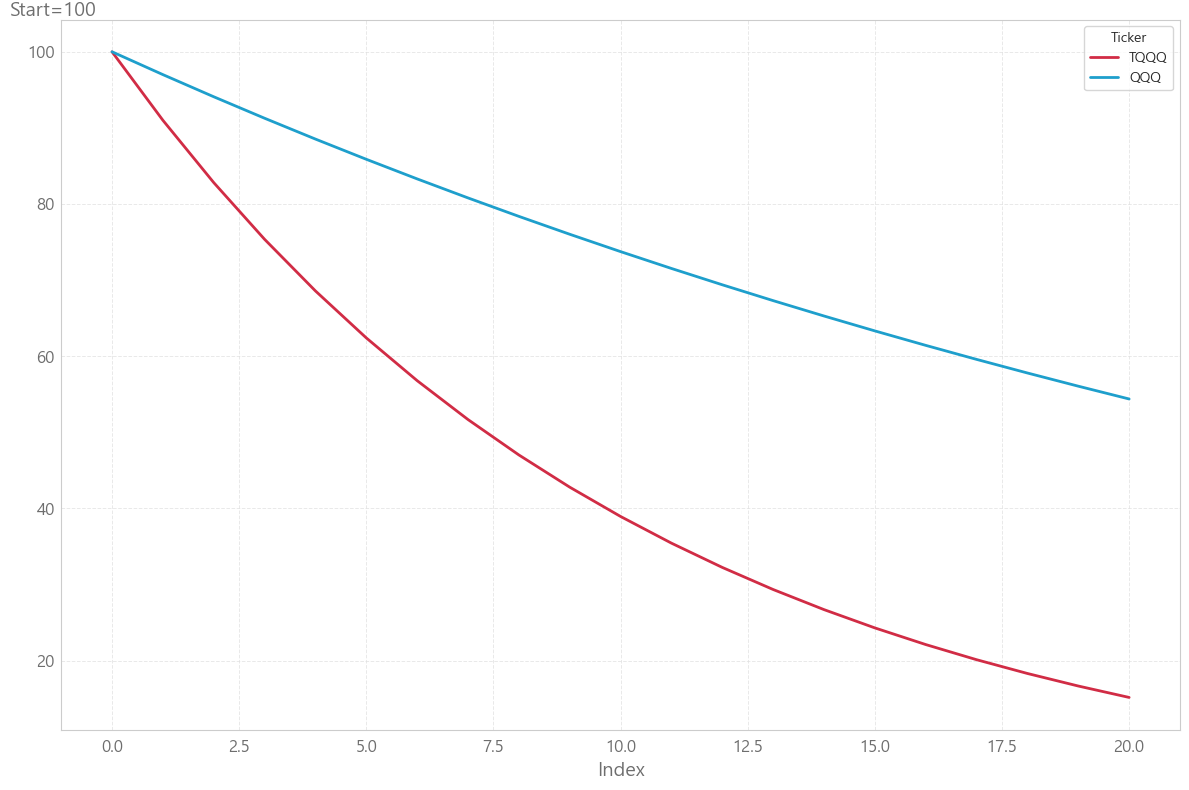

In [13]:
colors = [mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']]
_df = bear_df.reset_index()
_df = _df.melt(id_vars='index', value_vars=_df.columns, var_name='Ticker', value_name='Value')
lineplot = sns.lineplot(data=_df, x='index', y='Value', hue='Ticker', palette=colors, linestyle='-', linewidth=2)

plt.ylabel(f"Start=100", fontsize=14, labelpad=-50, loc="top", rotation=0, color=mycolors['color_around'])
plt.xlabel("Index", fontsize=14, color=mycolors['color_around'])
plt.xticks(fontsize=12, color=mycolors['color_around'])
plt.yticks(fontsize=12, color=mycolors['color_around'])

# Adjust tick params
plt.gca().tick_params(axis="y", pad=1)

# Add grid
plt.grid(color=mycolors["color_around2"], linestyle="--", linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

In [17]:
mycolors['color_norm2'], mycolors['color_cont'], mycolors['color_sub']

('#8E001C', '#1E9FCC', '#E59400')

In [16]:
mycolors['color_around2']

'#E0E0E0'

In [245]:
0.0309278350515463 * 3

0.0927835051546389

In [248]:
100 * 1.3 * 1.3

169.0

In [249]:
100 * 1.9 * 1.9

361.0